Lambda School Data Science

*Unit 2, Sprint 2, Module 4*

---

# Classification Metrics

- get and interpret the **confusion matrix** for classification models
- use classification metrics: **precision, recall**
- understand the relationships between precision, recall, **thresholds, and predicted probabilities**, to help **make decisions and allocate budgets**
- Get **ROC AUC** (Receiver Operating Characteristic, Area Under the Curve)

In [177]:
%%capture
import sys

# If you're on Colab:
if 'google.colab' in sys.modules:
    DATA_PATH = 'https://raw.githubusercontent.com/LambdaSchool/DS-Unit-2-Kaggle-Challenge/master/data/'
    !pip install category_encoders==2.*

# If you're working locally:
else:
    DATA_PATH = '../data/'

In [178]:
from category_encoders import OneHotEncoder, OrdinalEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, plot_confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
import pandas as pd

# I. Wrangle Data

## Import

In [179]:
train = pd.merge(pd.read_csv(DATA_PATH+'waterpumps/train_features.csv', na_values=[0, -2.000000e-08]), 
                 pd.read_csv(DATA_PATH+'waterpumps/train_labels.csv')).set_index('id')

test = pd.read_csv(DATA_PATH+'waterpumps/test_features.csv', na_values=[0, -2.000000e-08], index_col='id')

## EDA

- How can we transform our target so that this is a **binary classification** problem?

In [180]:
train['status_group'].value_counts()

functional                 32259
non functional             22823
functional needs repair     4317
Name: status_group, dtype: int64

In [181]:
# functional as positive class as '0' and then putting non functional and functional needs repair as 1

In [182]:
train['needs repair'] = train['status_group'].apply(lambda x: 0 if x=='functional' else 1)

In [183]:
train['status_group'].replace({'functional':0,
                               'non functional':1,
                               'functional needs repair':1}).head()

id
69572.0    0
8776.0     0
34310.0    0
67743.0    1
19728.0    0
Name: status_group, dtype: int64

In [184]:
(train['status_group'] != 'functional').astype(int).head() # pseudo code

id
69572.0    0
8776.0     0
34310.0    0
67743.0    1
19728.0    0
Name: status_group, dtype: int64

Our new wrangle function

In [185]:
def wrangle(X):
  # Make a copy
  X = X.copy()

  # Drop high cardinality cols
  high_card_cols = [col for col in X.select_dtypes('object').columns
                    if X[col].nunique() > 100]

  X.drop(columns=high_card_cols, inplace=True)

  # Drop repeated columns
  cols = ['extraction_type_group', 'quantity']
  X.drop(columns=cols, inplace=True)

  # Create new, binary target
  if 'status_group' in X.columns:
    X['needs_repair'] = (X['status_group'] != 'functional').astype(int)
    X.drop(columns='status_group', inplace=True)

  return X

In [186]:
train = wrangle(train)
test = wrangle(test)

In [187]:
train.head()

,amount_tsh,gps_height,longitude,latitude,num_private,basin,region,region_code,district_code,population,public_meeting,recorded_by,scheme_management,permit,construction_year,extraction_type,extraction_type_class,management,management_group,payment,payment_type,water_quality,quality_group,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group,needs repair,needs_repair
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
69572.0,6000.0,1390.0,34.938093,-9.856322,NaN,Lake Nyasa,Iringa,11,5.0,109.0,True,GeoData Consultants Ltd,VWC,False,1999.0,gravity,gravity,vwc,user-group,pay annually,annually,soft,good,enough,spring,spring,groundwater,communal standpipe,communal standpipe,0,0
8776.0,NaN,1399.0,34.698766,-2.147466,NaN,Lake Victoria,Mara,20,2.0,280.0,NaN,GeoData Consultants Ltd,Other,True,2010.0,gravity,gravity,wug,user-group,never pay,never pay,soft,good,insufficient,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe,0,0
34310.0,25.0,686.0,37.460664,-3.821329,NaN,Pangani,Manyara,21,4.0,250.0,True,GeoData Consultants Ltd,VWC,True,2009.0,gravity,gravity,vwc,user-group,pay per bucket,per bucket,soft,good,enough,dam,dam,surface,communal standpipe multiple,communal standpipe,0,0
67743.0,NaN,263.0,38.486161,-11.155298,NaN,Ruvuma / Southern Coast,Mtwara,90,63.0,58.0,True,GeoData Consultants Ltd,VWC,True,1986.0,submersible,submersible,vwc,user-group,never pay,never pay,soft,good,dry,machine dbh,borehole,groundwater,communal standpipe multiple,communal standpipe,1,1
19728.0,NaN,NaN,31.130847,-1.825359,NaN,Lake Victoria,Kagera,18,1.0,NaN,True,GeoData Consultants Ltd,NaN,True,NaN,gravity,gravity,other,other,never pay,never pay,soft,good,seasonal,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe,0,0


# II. Split Data

In [188]:
# Split TV / FM
target = 'needs_repair'
y = train[target]
X = train.drop(columns=target)

# Train-val split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Sanity check
assert len(X_train) + len(X_val) == len(X)

# Baseline

In [189]:
 y_train.value_counts(normalize=True) # 0 is the negative class and 1 is the positive class

0    0.542583
1    0.457417
Name: needs_repair, dtype: float64

In [190]:
print('Baseline Accuracy:', y_train.value_counts(normalize=True).max())

Baseline Accuracy: 0.5425829668132747


# Build Model

- `OrdinalEncoder`
- `SimpleImputer`
- `RandomForestClassifier`

In [191]:
y_train.isnull().sum()

0

In [192]:
# predictors for classification
# Logistics Regression, Decision Tree Classifier, Random Forest Classifier

# which one would you like to choose Random Forest as it is an ensemble approach of getting best model 
model = make_pipeline(
    OrdinalEncoder(),
    SimpleImputer(),
    RandomForestClassifier(n_jobs=-1, random_state=42, n_estimators=50)
)

model.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('ordinalencoder',
                 OrdinalEncoder(cols=['basin', 'region', 'public_meeting',
                                      'recorded_by', 'scheme_management',
                                      'permit', 'extraction_type',
                                      'extraction_type_class', 'management',
                                      'management_group', 'payment',
                                      'payment_type', 'water_quality',
                                      'quality_group', 'quantity_group',
                                      'source', 'source_type', 'source_class',
                                      'waterpoint_type',
                                      'w...
                 RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                        class_weight=None, criterion='gini',
                                        max_depth=None, max_features='auto',
                                

# Check Metrics

**Accuracy**

In [193]:
# accuracy
print('Training Accuracy', model.score(X_train,y_train))
print('Validation Accuracy', model.score(X_val,y_val))


Training Accuracy 1.0
Validation Accuracy 1.0


In [194]:
print('Training Accuracy:', model.score(X_train, y_train))
print('Validation Accuracy:', model.score(X_val, y_val))

Training Accuracy: 1.0
Validation Accuracy: 1.0


**Confusion Matrix**

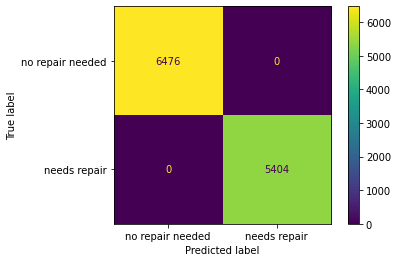

In [212]:
plot_confusion_matrix(model, X_val, y_val, values_format='.0f', display_labels=['no repair needed', 'needs repair'])

**Recall:** Of those pumps that actually needed repair, what proportion did you correctly predict as needing repair?

In [196]:
print('Recall:', 4135 / (4135 + 1269))

Recall: 0.7651739452257587


**Precision:** Of all the pumps that you predicted as needing repair, what proportion actually needed repair?

In [197]:
print('Precision:', 4135 / (4135 + 875))

Precision: 0.8253493013972056


**Classification Report**

In [215]:
print(classification_report(y_val, model.predict(X_val), target_names=['no repair needed', 'needs repair']))

                  precision    recall  f1-score   support

no repair needed       1.00      1.00      1.00      6476
    needs repair       1.00      1.00      1.00      5404

        accuracy                           1.00     11880
       macro avg       1.00      1.00      1.00     11880
    weighted avg       1.00      1.00      1.00     11880



In [218]:
model.predict(X_val)[:10]

array([1, 0, 0, 0, 0, 1, 0, 1, 0, 0])

In [222]:
model.predict_proba(X_val)[:10,-1]

array([1.  , 0.02, 0.  , 0.02, 0.  , 1.  , 0.  , 1.  , 0.14, 0.  ])

# Case Study

Let's say that is costs the Tanzanian government $100 to inspect a water pump, and there is only funding for 2000 pump inspections. 

In [201]:
n_inspections = 2000

Scenario 1: Choose pumps randomly

In [224]:
y_val.value_counts(normalize=True).min()
# I will be wrong 45% of the time if I were to send people to repair a pump without any model

0.4548821548821549

In [225]:
repair_prob = y_val.value_counts(normalize=True).min()

print('Inspections conducted:', n_inspections)
print('Pumps repaired:', round(n_inspections * repair_prob))
print('Funds wasted:', n_inspections * (1-repair_prob) * 100)

Inspections conducted: 2000
Pumps repaired: 910
Funds wasted: 109023.56902356903


Scenario 2: Using our model "out of the box"

In [227]:
data = {'y_val': y_val,
        'y_pred': model.predict(X_val)}
results = pd.DataFrame(data)
mask = results['y_pred'] == 1
sample = results[mask].sample(n_inspections)

# print('Inspections Conducted', n_inspections)
sample

,y_val,y_pred
id,,
31010.0,1,1
66538.0,1,1
40589.0,1,1
44984.0,1,1
31214.0,1,1
...,...,...
22164.0,1,1
42008.0,1,1
47607.0,1,1


In [204]:
data = {'y_val': y_val,
        'y_pred': model.predict(X_val)}

results = pd.DataFrame(data)

mask = results['y_pred'] == 1
sample = results[mask].sample(n_inspections)

print('Inspections conducted:', n_inspections)
print('Pumps repaired:', sample['y_val'].sum())
print('Funds wasted:', (n_inspections - sample.y_val.sum()) * 100)

Inspections conducted: 2000
Pumps repaired: 2000
Funds wasted: 0


Scenario 3: We empasize **precision** in our model, and only select pumps that our model is very certain (`>0.9`) need repair.

In [205]:
data = {'y_val': y_val,
       'y_pred_proba': model.predict_proba(X_val)[:, -1]}

results = pd.DataFrame(data)

threshold = 0.9

mask = results['y_pred_proba'] > threshold
sample = results[mask].sample(n_inspections)

print('Inspections conducted:', n_inspections)
print('Pumps repaired:', sample['y_val'].sum())
print('Funds wasted:', (n_inspections - sample.y_val.sum()) * 100)

Inspections conducted: 2000
Pumps repaired: 2000
Funds wasted: 0
